## Imports

In [14]:
import sys
import os

current_dir = os.getcwd() 
sys.path.append(os.path.join(current_dir, '..'))

import numpy as np
import matplotlib.pyplot as plt

# Traffic Signal Controller Reinforcement Learning Modules
from tscRL.environments.environment import SumoEnvironment, TrafficLight as tl
from tscRL.agents.ql_agent import QLAgent

# Include sumo-tools directory
if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")



## Hyperparameter tuning

### Epsilon Greedy Policy

#### Estrategias para decaer Epsilon en Epsilon-Greedy 

In [15]:
# Exponencial
def calculate_exp_epsilon(decayRate, steps, startEpsilon=1.0, endEpsilon=0.001):
    x = np.arange(steps)
    y = endEpsilon + (startEpsilon - endEpsilon) * np.exp(-decayRate * x)
    return x, y

# Lineal
def calculate_linear_epsilon(steps, startEpsilon=1.0, endEpsilon=0.001):
    slope = (startEpsilon - endEpsilon) / steps
    x = np.arange(steps)
    y = startEpsilon - slope * x
    y = np.maximum(y, endEpsilon)  # Asegura que el valor mínimo sea endEpsilon
    return x, y

#### Decay rates
Rasa con la que decae epsilon a través de los pasos de tiempo (steps)

In [16]:
decay_rates = [0.001, 0.0005, 0.0003, 0.0002, 0.0001]

#### Análisis de funciones epsilon a través del tiempo

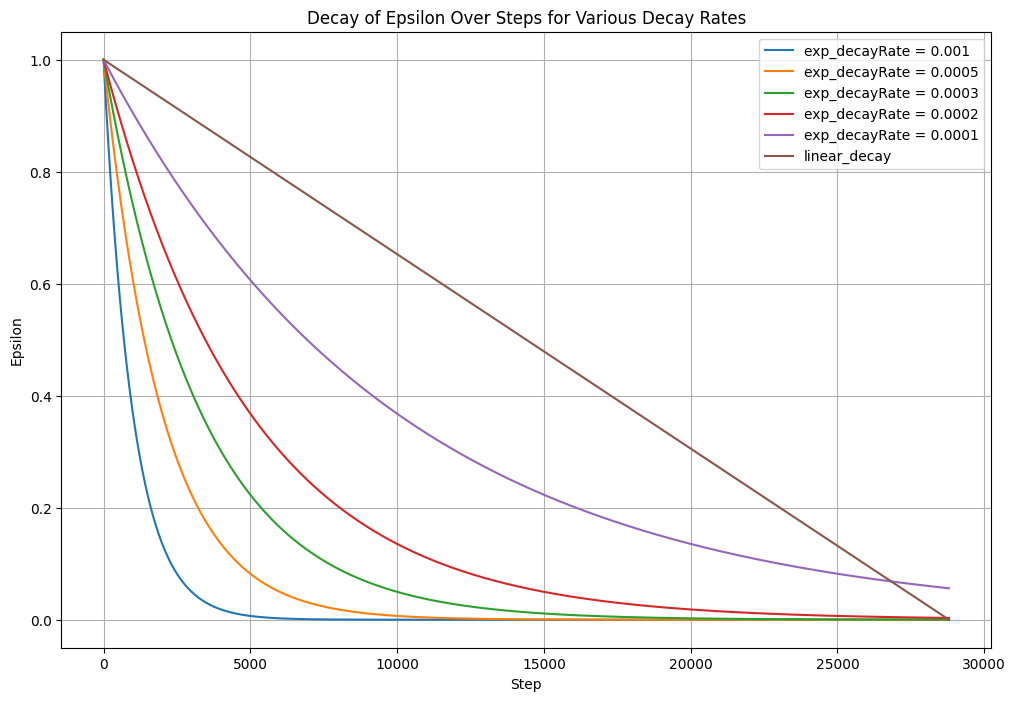

In [17]:
simulationSteps = 86400
steps = simulationSteps // 3

endEpsilon = 0.01
startEpsilon = 1

plt.figure(figsize=(12, 8))

for decayRate in decay_rates:
    x, y = calculate_exp_epsilon(decayRate, steps)
    plt.plot(x, y, label=f'exp_decayRate = {decayRate}')

x, y = calculate_linear_epsilon(steps)
plt.plot(x, y, label=f'linear_decay')

plt.xlabel('Step')
plt.ylabel('Epsilon')
plt.title('Decay of Epsilon Over Steps for Various Decay Rates')
plt.legend()
plt.grid(True)
plt.show()

### Q-Learning - Parámetros

#### Delta time
Tiempo de simulación (en segundos) entre pasos (steps)

In [18]:
delta_time = [3,5]

#### Phases
Posibles fases de un semáforo. Determina el espacio de acción (action space)

In [19]:
phases = [{'init':   tl.Phase("rrrrrrrrrrrrrrrr", "rrrrrrrrrrrrrrrr"),
        'ns_sn_l':   tl.Phase("GGGgrrrrGGGgrrrr", "yyyyrrrryyyyrrrr"), #
        'ew_we_l':   tl.Phase("rrrrGGGgrrrrGGGg", "rrrryyyyrrrryyyy"), #
        'sn':        tl.Phase("rrrrrrrrGGGGrrrr", "rrrrrrrryyyyrrrr"),
        'ns':        tl.Phase("GGGGrrrrrrrrrrrr", "yyyyrrrrrrrrrrrr"),
        'we':        tl.Phase("rrrrrrrrrrrrGGGG", "rrrrrrrrrrrryyyy"),
        'ew':        tl.Phase("rrrrGGGGrrrrrrrr", "rrrryyyyrrrrrrrr"),
        'ns_sn':     tl.Phase("GGGrrrrrGGGrrrrr", "yyyrrrrryyyrrrrr"),
        'ew_we':     tl.Phase("rrrrGGGrrrrrGGGr", "rrrryyyrrrrryyyr"),
        },
        {'init':     tl.Phase("rrrrrrrrrrrrrrrr", "rrrrrrrrrrrrrrrr"),
        'sn':        tl.Phase("rrrrrrrrGGGGrrrr", "rrrrrrrryyyyrrrr"),
        'ns':        tl.Phase("GGGGrrrrrrrrrrrr", "yyyyrrrrrrrrrrrr"),
        'we':        tl.Phase("rrrrrrrrrrrrGGGG", "rrrrrrrrrrrryyyy"),
        'ew':        tl.Phase("rrrrGGGGrrrrrrrr", "rrrryyyyrrrrrrrr"),
        'ns_sn':     tl.Phase("GGGrrrrrGGGrrrrr", "yyyrrrrryyyrrrrr"),
        'ew_we':     tl.Phase("rrrrGGGrrrrrGGGr", "rrrryyyrrrrryyyr"),
        'ne_sw':     tl.Phase("rrrGrrrrrrrGrrrr", "rrryrrrrrrryrrrr"),   #
        'wn_es':     tl.Phase("rrrrrrrGrrrrrrrG", "rrrrrrryrrrrrrry")    #
        },
        {'init':     tl.Phase("rrrrrrrrrrrrrrrr", "rrrrrrrrrrrrrrrr"),
        'ns_sn':     tl.Phase("GGGrrrrrGGGrrrrr", "yyyrrrrryyyrrrrr"),
        'ew_we':     tl.Phase("rrrrGGGrrrrrGGGr", "rrrryyyrrrrryyyr"),
        'ne_sw':     tl.Phase("rrrGrrrrrrrGrrrr", "rrryrrrrrrryrrrr"),   #
        'wn_es':     tl.Phase("rrrrrrrGrrrrrrrG", "rrrrrrryrrrrrrry")    #
        },
        {'init':     tl.Phase("rrrrrrrrrrrrrrrr", "rrrrrrrrrrrrrrrr"),
        'sn':        tl.Phase("rrrrrrrrGGGGrrrr", "rrrrrrrryyyyrrrr"),
        'ns':        tl.Phase("GGGGrrrrrrrrrrrr", "yyyyrrrrrrrrrrrr"),
        'we':        tl.Phase("rrrrrrrrrrrrGGGG", "rrrrrrrrrrrryyyy"),
        'ew':        tl.Phase("rrrrGGGGrrrrrrrr", "rrrryyyyrrrrrrrr"),
        }]
             
encodeIntervals = [3, 6, 10, 16]

#### Edges
Parámetro que determina si se usaran aristas (edges), en vez de carriles (lanes). En la siguiente figura se puede observar la diferencia


<div style="text-align:center;"><img src="./images/lane_vs_edge.png" alt="lane vs edge" width="800"></div>





In [20]:
edges = [True, False]

#### Intervalos de codificación
Cantidad de intervalos que se usarán para codificar (discretizar) los estados.


In [21]:
encodeIntervals = [3, 6, 10, 16]

#### Función de recompensa
Para computar la recompensa se cuenta con dos funciones:
- Diferencia de sumatoria de todos los tiempos de espera (*diff_waitingTime*)
- Diferencia de vehículos detenidos (*diff_halted*)

In [22]:
# rewardFn = ["diff_halted", "diff_waitingTime"]
rewardFn = list(SumoEnvironment.rewardFns.keys())

#### Lane Info
Que información es más relevante para capturar el estado de tráfico en un carril (o arista)?

In [23]:
laneInfo = ["halted", "waitingTime"]

## Primer Training

In [ ]:
sumoCfgFile = os.path.abspath(os.path.join(current_dir, '../../nets/2x2_intersection/interseccion.sumocfg'))

env = SumoEnvironment(sumocfgFile=sumoCfgFile, deltaTime=5, yellowTime=3, minGreenTime=10, maxGreenTime=60, gui=False, edges=False, discreteIntervals=6, laneInfo="halted", rewardFn="diff_waitingTime")

agent = QLAgent(env, 0.99, 0.1, 0.05, 0.005, 1.0)

agent.train(3);


In [ ]:
agent.qTable

In [ ]:
env.metrics.reward